<a href="https://colab.research.google.com/github/girijeshcse/car_finder/blob/nitya/notebooks/Data_Pre_process_%26_EDA_CVS/h5%20file%20does%20not%20work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import os
import cv2
import sys
import numpy as np
import pandas as pd
import decimal
from tqdm import tqdm
#np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import pickle
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

# Declare path

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
BASE_PATH = '/content/drive/MyDrive/Capstone/Dataset_1/Dataset'
EDIT_PATH = '/content/drive/MyDrive/Capstone/Dataset_1'
TRAIN_IMAGES_PATH = os.path.sep.join([BASE_PATH, "Car Images/Train Images"])
TEST_IMAGES_PATH = os.path.sep.join([BASE_PATH, "Car Images/Test Images"])
TRAIN_ANNOTS_PATH = os.path.sep.join([BASE_PATH, "Annotations/Train Annotations.csv"])
TEST_ANNOTS_PATH = os.path.sep.join([BASE_PATH, "Annotations/Test Annotation.csv"])
CAR_NAMES_MAKE_DICT = os.path.sep.join([BASE_PATH, "Car names and make.csv"])

# Display annotation & car-make file

In [ ]:
train_annotate=pd.read_csv(TRAIN_ANNOTS_PATH)
train_annotate.rename(columns={'Image Name':'imagename','Bounding Box coordinates': 'x0', 'Unnamed: 2': 'y0','Unnamed: 3': 'x1','Unnamed: 4': 'y1'}, inplace=True)
test_annotate=pd.read_csv(TEST_ANNOTS_PATH)
test_annotate.rename(columns={'Image Name':'imagename','Bounding Box coordinates': 'x0', 'Unnamed: 2': 'y0','Unnamed: 3': 'x1','Unnamed: 4': 'y1'}, inplace=True)

In [ ]:
car_map = pd.read_csv(CAR_NAMES_MAKE_DICT,names=['Cars'])
car_map = car_map.set_index('Cars')
car_map_dict=car_map.to_dict('index')
list(car_map_dict.items())[:5]
#fetch a key based on value passed - we need this to build our image paths
print(list(car_map_dict.keys())[173])

Ram C/V Cargo Van Minivan 2012


# Pre-process train data

# Function to create data frame with image name, image array, car-make

In [ ]:
IMAGESIZE=224
dfRows=[]
for dirname, _, filenames in os.walk(TRAIN_IMAGES_PATH):
  limit=0
  if len(filenames) < 200 or 200 == 0:
    limit=len(filenames)
  else:
    limit=200
  for i in range(0,limit):
    if not os.path.isfile(os.path.join(TRAIN_IMAGES_PATH, filenames[i])):
      processedRows=[]
      filename=filenames[i]
      imagePathtrain=os.path.join(dirname, filename)
      processedRows.append(imagePathtrain)
      pathSplits=imagePathtrain.split('/')[-1]
      pathSplits1=imagePathtrain.split('/')[-2]
      processedRows.append(pathSplits)
      processedRows.append(pathSplits1)
      processedRows.append(pathSplits1[-4:])
      image = cv2.imread(imagePathtrain)
      height = image.shape[0]
      width = image.shape[1]
      processedRows.append(height)
      processedRows.append(width)
      # load the image and preprocess it
      image = load_img(imagePathtrain, target_size=(224, 224))
      image_array = np.array(img_to_array(image),dtype=np.float32)
      processedRows.append(image_array)
      train_annotate_imagename = train_annotate.iloc[i,0]
      for i in range(0,len(train_annotate)):
        train_annotate_imagename = train_annotate.iloc[i,0]
        if  train_annotate_imagename == filename:
          x0 = train_annotate.iloc[i,1]
          y0 = train_annotate.iloc[i,2]
          x1 = train_annotate.iloc[i,3]
          y1 = train_annotate.iloc[i,4]
          imageclass = train_annotate.iloc[i,5]
          processedRows.append(x0)
          processedRows.append(y0)
          processedRows.append(x1)
          processedRows.append(y1)
          processedRows.append(imageclass)
          x0_scaled=float(x0)/width*IMAGESIZE
          y0_scaled=float(y0)/height*IMAGESIZE
          x1_scaled=float(x1)/width*IMAGESIZE
          y1_scaled=float(y1)/height*IMAGESIZE
          processedRows.append(x0_scaled)
          processedRows.append(y0_scaled)
          processedRows.append(x1_scaled)
          processedRows.append(y1_scaled)
          dfRows.append(processedRows)
          train_image=pd.DataFrame(dfRows, columns=["imagepath","imagename","carname","caryear","height","width","imagearray","x0","y0","x1","y1","imageclass","x0_scaled","y0_scaled","x1_scaled","y1_scaled"])

In [ ]:
#train_image.to_csv(EDIT_PATH+'/train_image.csv')

In [ ]:
#train_merged = pd.read_csv(EDIT_PATH+'/train_image.csv')

Unnamed: 0            int64
imagepath            object
imagename            object
carname              object
caryear               int64
height                int64
width                 int64
imagearray           object
imagearrayscaled     object
x0                    int64
y0                    int64
x1                    int64
y1                    int64
imageclass            int64
x0_scaled           float64
y0_scaled           float64
x1_scaled           float64
y1_scaled           float64
dtype: object

In [ ]:
train_image.to_hdf(EDIT_PATH+'/train_image_1.h5',key='train_image', mode='w')

NameError: ignored

In [ ]:
train_merged = pd.read_hdf(EDIT_PATH+'/train_image_1.h5','train_image')

# Test bounding box

151
Unnamed: 0                                                        151
imagepath           /content/drive/MyDrive/Capstone/Dataset_1/Data...
imagename                                                   05224.jpg
carname                                    AM General Hummer SUV 2000
caryear                                                          2000
height                                                             62
width                                                              93
imagearray          [[[193. 131.  82.]\n  [193. 131.  82.]\n  [200...
imagearrayscaled    [[[0.75686276 0.5137255  0.32156864]\n  [0.756...
x0                                                                  5
y0                                                                 14
x1                                                                 93
y1                                                                 58
imageclass                                                          1
x0_scaled       

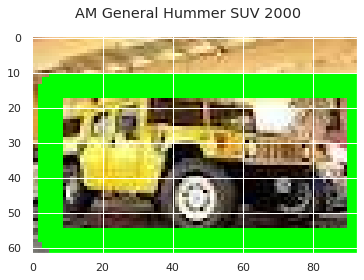

In [ ]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd

#Pickup a random image number
img_num = np.random.randint(0, train_merged.shape[0])
print(img_num)
# print(train_merged.columns)
print(train_merged.loc[img_num])
img_path = os.path.join(train_merged.loc[img_num,'imagepath'])
#Read the image and draw a rectangle as per bounding box information
img = cv2.imread(img_path)
print(img_path)
cv2.rectangle(img, 
             (train_merged.loc[img_num, 'x0'],train_merged.loc[img_num, 'y0']),
             (train_merged.loc[img_num, 'x1'],train_merged.loc[img_num, 'y1']), 
             (0,255,0),
             6)
#Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Draw image using matplotlib
plt.suptitle(train_merged.loc[img_num, 'carname'])
plt.imshow(img)
plt.show()

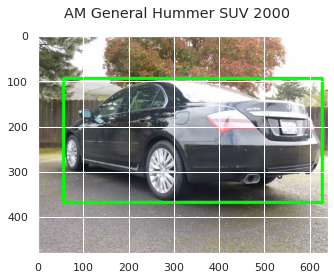

In [ ]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
imagename='/Acura RL Sedan 2012/01891.jpg'
img_path = TRAIN_IMAGES_PATH +imagename
#img_num=01891.jpg
#Read the image and draw a rectangle as per bounding box information
img = cv2.imread(img_path)
cv2.rectangle(img, 
             (train_merged.loc[train_merged['imagepath']==img_path,'x0'],train_merged.loc[train_merged['imagepath']==img_path, 'y0']),
             (train_merged.loc[train_merged['imagepath']==img_path, 'x1'],train_merged.loc[train_merged['imagepath']==img_path, 'y1']), 
             (0,255,0),
             6)
#Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Draw image using matplotlib
plt.suptitle(train_merged.loc[img_num, 'carname'])
plt.imshow(img)
plt.show()

# Pre-process test data

In [ ]:
'''
IMAGESIZE=224
dfRows=[]
for dirname, _, filenames in os.walk(TEST_IMAGES_PATH):
  limit=0
  if len(filenames) < 200 or 200 == 0:
    limit=len(filenames)
  else:
    limit=200
  for i in range(0,limit):
    if not os.path.isfile(os.path.join(TEST_IMAGES_PATH, filenames[i])):
      processedRows=[]
      filename=filenames[i]
      imagePathtrain=os.path.join(dirname, filename)
      processedRows.append(imagePathtrain)
      pathSplits=imagePathtrain.split('/')[-1]
      pathSplits1=imagePathtrain.split('/')[-2]
      processedRows.append(pathSplits)
      processedRows.append(pathSplits1)
      processedRows.append(pathSplits1[-4:])
      image = cv2.imread(imagePathtrain)
      height = image.shape[0]
      width = image.shape[1]
      processedRows.append(height)
      processedRows.append(width)
      # load the image and preprocess it
      image = load_img(imagePathtrain, target_size=(224, 224))
      image_array = np.array(img_to_array(image),dtype=np.float32)
      processedRows.append(image_array)
      test_annotate_imagename = test_annotate.iloc[i,0]
      for i in range(0,len(test_annotate)):
        test_annotate_imagename = test_annotate.iloc[i,0]
        if  test_annotate_imagename == filename:
          x0 = test_annotate.iloc[i,1]
          y0 = test_annotate.iloc[i,2]
          x1 = test_annotate.iloc[i,3]
          y1 = test_annotate.iloc[i,4]
          imageclass = test_annotate.iloc[i,5]
          processedRows.append(x0)
          processedRows.append(y0)
          processedRows.append(x1)
          processedRows.append(y1)
          processedRows.append(imageclass)
          x0_scaled=float(x0)/width*IMAGESIZE
          y0_scaled=float(y0)/height*IMAGESIZE
          x1_scaled=float(x1)/width*IMAGESIZE
          y1_scaled=float(y1)/height*IMAGESIZE
          processedRows.append(x0_scaled)
          processedRows.append(y0_scaled)
          processedRows.append(x1_scaled)
          processedRows.append(y1_scaled)
          dfRows.append(processedRows)
          test_image=pd.DataFrame(dfRows, columns=["imagepath","imagename","carname","caryear","height","width","imagearray","x0","y0","x1","y1","imageclass","x0_scaled","y0_scaled","x1_scaled","y1_scaled"])'''

'dfRows=[]\nfor dirname, _, filenames in os.walk(TEST_IMAGES_PATH):\n  limit=0\n  if len(filenames) < 200 or 200 == 0:\n    limit=len(filenames)\n  else:\n    limit=200\n  for i in range(0,limit):\n    if not os.path.isfile(os.path.join(TEST_IMAGES_PATH, filenames[i])):\n      processedRows=[]\n      filename=filenames[i]\n      imagePathtrain=os.path.join(dirname, filename)\n      processedRows.append(imagePathtrain)\n      pathSplits=imagePathtrain.split(\'/\')[-1]\n      pathSplits1=imagePathtrain.split(\'/\')[-2]\n      processedRows.append(pathSplits)\n      processedRows.append(pathSplits1)\n      processedRows.append(pathSplits1[-4:])\n      image = cv2.imread(imagePathtrain)\n      height = image.shape[0]\n      width = image.shape[1]\n      processedRows.append(height)\n      processedRows.append(width)\n      # load the image and preprocess it\n      image = load_img(imagePathtrain, target_size=(224, 224))\n      image_array = img_to_array(image)\n      image_array_scaled = i

In [ ]:
#test_image.to_csv(EDIT_PATH+'/test_image.csv')

In [ ]:
#test_merged = pd.read_csv(EDIT_PATH+'/test_image.csv')

In [ ]:
test_image.to_hdf(EDIT_PATH+'/test_image_1.h5',key='test_image', mode='w')

In [ ]:
test_merged = pd.read_hdf(EDIT_PATH+'/test_image_1.h5','test_image')

# Perform EDA

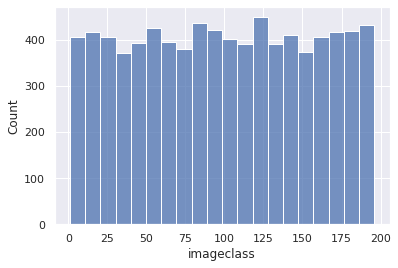

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.histplot(x= train_merged['imageclass'],bins = 20)
# # From above histogram it is clear that we have almost equal density distribution among car classes in training data df

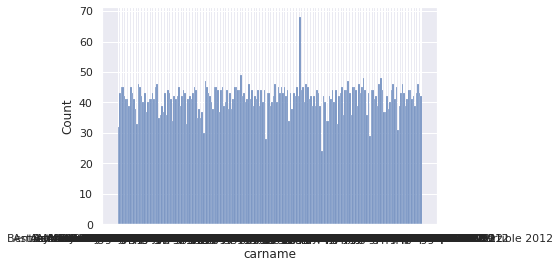

In [ ]:
sns.histplot(train_merged['carname'])

# Train Test split

In [ ]:
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
le = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
train_merged['carname_class']=le.fit_transform(train_merged['carname'])
test_merged['carname_class']= le.fit_transform(test_merged['carname'])
trainlabels=train_merged['carname_class']
testlabels=test_merged['carname_class']

In [ ]:
IMAGESIZE=224
len_train = train_merged.shape[0]

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import preprocess_input
x_train = np.zeros((len_train, IMAGESIZE, IMAGESIZE, 3))
y_train = np.zeros((len_train, 4))
y_train_class = train_merged['carname_class']
for i in range(len(train_merged)) :
  x_train[i] = preprocess_input(np.array(float(train_merged.loc[i,'imagearray']).reshape(IMAGESIZE, IMAGESIZE, 3), dtype=np.float32))
  y_train[i] = train_merged.loc[i, 'x0_scaled':'y1_scaled']

In [ ]:
'''from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image
x_train = np.zeros((len_train,IMAGESIZE,IMAGESIZE,3))
y_train = np.zeros((len_train, 4))
y_train_class = train_merged['carname_class']
for i, f in enumerate(tqdm(path)):
  img = image.load_img(f, target_size=(IMAGESIZE,IMAGESIZE))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  x_train[i] = preprocess_input(img) # Convert to float32 array
  y_train[i] = train_merged.loc[i, 'x0_scaled1':'y1_scaled1']'''

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(y_train_class.shape)

In [ ]:
len_test1 = test_merged.shape[0]

In [ ]:
'''test_merged['x0_scaled1']=(test_merged['x0_scaled']*IMAGESIZE)
test_merged['y0_scaled1']=(test_merged['y0_scaled']*IMAGESIZE)
test_merged['x1_scaled1']=(test_merged['x1_scaled']*IMAGESIZE)
test_merged['y1_scaled1']=(test_merged['y1_scaled']*IMAGESIZE)'''

In [ ]:
'''from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image
x_test = np.zeros((len_test1,IMAGESIZE,IMAGESIZE,3))
y_test = np.zeros((len_test1, 4))
y_test_class = test_merged['carname_class']
for i, f in enumerate(tqdm(path1)):
  img = image.load_img(f, target_size=(IMAGESIZE,IMAGESIZE))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  x_test[i] = preprocess_input(img) # Convert to float32 array
  y_test[i] = test_merged.loc[i, 'x0_scaled1':'y1_scaled1']

In [ ]:
print(x_test.shape)
print(y_test.shape)
print(y_test_class.shape)

In [ ]:
# construct a dictionary for our target training outputs
y_train1 = {
	"class_label": y_train_class,
	"bounding_box": y_train
}
# construct a second dictionary, this one for our target testing
y_test1 = {
	"class_label":  y_test_class,
	"bounding_box": y_test
}

# VGG

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception # TensorFlow ONLY
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import argparse
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape

In [ ]:
INIT_LR = 1e-4

# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",	name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(le.classes_), activation="softmax",	name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))

# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
#model.compile(loss="mse", optimizer=opt, metrics=["accuracy"])

print(model.summary())

In [ ]:
NUM_EPOCHS = 20
BATCH_SIZE = 32

# train the network for bounding box regression
print("[INFO] training bounding box regressor...")

H = model.fit(
	x_train, y_train,
	validation_data=(x_test, y_test),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

In [ ]:
# The path to our TensorFlow-serialized output model
MODEL_PATH = os.path.sep.join([BASE_PATH, BASE_OUTPUT, "detector.h5"])
LB_PATH = os.path.sep.join([BASE_PATH, BASE_OUTPUT, "lb.pickle"])

# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

In [ ]:
# The output training history plot consisting of accuracy and loss curves
PLOT_PATH = os.path.sep.join([BASE_PATH, BASE_OUTPUT, "plots"])

# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join([PLOT_PATH, "losses.png"])
plt.savefig(plotPath)